# Building Content Based Recommender System using Python

## Introduction

Pada bagian sebelumnya kita telah melihat bagaimana recommender system dibuat hanya dengan menggunakan average rating, dengan mengurutkan score yang terdapat komponen average rating secara descending, kita dapat mengetahui (secara estimasi) film mana yang menurut para audience paling menarik.

Kali ini, kita akan membuat recommender system yang menggunakan Content/feature dari film/entitas tersebut, kemudian melakukan perhitungan terhadap kesamaannya satu dan yang lain sehingga ketika kita menunjuk ke satu film, kita akan mendapat beberapa film lain yang memiliki kesamaan dengan film tersebut. 
Hal ini biasa kita sebut sebagai Content Based Recommender System.

## Example

dengan membandingkan kesamaan plot yang ada dan genre yang ada, ketika audience lebih menyukai film Narnia, maka content based recommender system ini akan juga merekomendasikan film seperti Harry Potter atau The Lords of The Rings yang memiliki genre yang mirip

## Reference
https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/f13439b5-0b39-4bf7-a674-d531265bac4a.xhtml

## Script

### Task 1: Unloading and checking datasets

In [153]:
#import basic libraries

import pandas as pd
import numpy as np

In [154]:
movie_rating_df = pd.read_csv('movie_rating_df.csv')
movie_rating_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short",5.6,1608
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short",6.0,197
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance",6.5,1285
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short",6.1,121
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short",6.1,2050


In [155]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751614 entries, 0 to 751613
Data columns (total 11 columns):
tconst            751614 non-null object
titleType         751614 non-null object
primaryTitle      751614 non-null object
originalTitle     751614 non-null object
isAdult           751614 non-null int64
startYear         751614 non-null float64
endYear           16072 non-null float64
runtimeMinutes    751614 non-null float64
genres            486766 non-null object
averageRating     751614 non-null float64
numVotes          751614 non-null int64
dtypes: float64(4), int64(2), object(5)
memory usage: 63.1+ MB


dari table di atas, kita bisa mendapatkan list film dengan beberapa metadata nya seperti isAdult, runtimeMinutes, dan genres nya

selanjutnya kita akan menambahkan metadata lain seperti aktor/aktris yang bermain di film tersebut, kita akan bermain dengan dataframe lain kemudian akan melakukan join dengan dataframe di atas

In [156]:
name_df = pd.read_csv('actor_name.csv')
name_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm1774132,Nathan McLaughlin,1973,\N,"special_effects,make_up_department","tt0417686,tt1713976,tt1891860,tt0454839"
1,nm10683464,Bridge Andrew,\N,\N,actor,tt7718088
2,nm1021485,Brandon Fransvaag,\N,\N,miscellaneous,tt0168790
3,nm6940929,Erwin van der Lely,\N,\N,miscellaneous,tt4232168
4,nm5764974,Svetlana Shypitsyna,\N,\N,actress,tt3014168


pertama-tama kita tahu bahwa terdapat value NULL dengan format '\\N', kita akan menghapus data ini dari table dahulu

In [157]:
name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
nconst               1000 non-null object
primaryName          1000 non-null object
birthYear            1000 non-null object
deathYear            1000 non-null object
primaryProfession    891 non-null object
knownForTitles       1000 non-null object
dtypes: object(6)
memory usage: 47.0+ KB


In [250]:
director_writers = pd.read_csv('directors_writers.csv')
director_writers.head()

,tconst,director_name,writer_name
0,tt0011414,David Kirkland,"John Emerson,Anita Loos"
1,tt0011890,Roy William Neill,"Arthur F. Goodrich,Burns Mantle,Mary Murillo"
2,tt0014341,"Buster Keaton,John G. Blystone","Jean C. Havez,Clyde Bruckman,Joseph A. Mitchell"
3,tt0018054,Cecil B. DeMille,Jeanie Macpherson
4,tt0024151,James Cruze,"Max Miller,Wells Root,Jack Jevne"


In [251]:
director_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
tconst           986 non-null object
director_name    986 non-null object
writer_name      986 non-null object
dtypes: object(3)
memory usage: 23.2+ KB


In [252]:
director_writers.isnull().sum()

tconst           0
director_name    0
writer_name      0
dtype: int64

untuk table director_writers tidak perlu dicleansing lagi karena sudah benar format dan isi datanya, cuma kita perlu untuk ubah director_name dan writer_name dari string menjadi list

In [253]:
director_writers['director_name'] = director_writers['director_name'].apply(lambda row: row.split(','))
director_writers['writer_name'] = director_writers['writer_name'].apply(lambda row: row.split(','))
director_writers.head()

,tconst,director_name,writer_name
0,tt0011414,[David Kirkland],"[John Emerson, Anita Loos]"
1,tt0011890,[Roy William Neill],"[Arthur F. Goodrich, Burns Mantle, Mary Murillo]"
2,tt0014341,"[Buster Keaton, John G. Blystone]","[Jean C. Havez, Clyde Bruckman, Joseph A. Mitc..."
3,tt0018054,[Cecil B. DeMille],[Jeanie Macpherson]
4,tt0024151,[James Cruze],"[Max Miller, Wells Root, Jack Jevne]"


### Task 2: Cleaning and Processing table cast

kita akan cuma butuh kolom nconst, primaryName, dan knownForTitles untuk match aktor/aktris ini dengan film yang ada

In [158]:
name_df = name_df[['nconst','primaryName','knownForTitles']]
name_df.head()

,nconst,primaryName,knownForTitles
0,nm1774132,Nathan McLaughlin,"tt0417686,tt1713976,tt1891860,tt0454839"
1,nm10683464,Bridge Andrew,tt7718088
2,nm1021485,Brandon Fransvaag,tt0168790
3,nm6940929,Erwin van der Lely,tt4232168
4,nm5764974,Svetlana Shypitsyna,tt3014168


In [159]:
name_df['knownForTitles'].apply(lambda x: len(x.split(','))).unique()

array([4, 1, 2, 3])

masing-masing pemain dapat bermain di 1 sampai 4 film berdasarkan data di atas, maka akan diperlukan untuk membuat table mempunyai relasi 1-1 ke masing-masing title movie tersebut, kita akan melakukan unnest terhadap table tersebut.
Pertama-tama kita membutuhkan kolom 'knownForTitles' menjadi list of list dahulu

In [160]:
name_df['knownForTitles'] = name_df['knownForTitles'].apply(lambda x: x.split(','))

In [161]:
name_df.head()

,nconst,primaryName,knownForTitles
0,nm1774132,Nathan McLaughlin,"[tt0417686, tt1713976, tt1891860, tt0454839]"
1,nm10683464,Bridge Andrew,[tt7718088]
2,nm1021485,Brandon Fransvaag,[tt0168790]
3,nm6940929,Erwin van der Lely,[tt4232168]
4,nm5764974,Svetlana Shypitsyna,[tt3014168]


In [162]:
#menyiapkan bucket untuk dataframe
df_uni = []

for x in ['knownForTitles']:
    #mengulang index dari tiap baris sampai tiap elemen dari knownForTitles
    idx = name_df.index.repeat(name_df['knownForTitles'].str.len())
    #memecah values dari list di setiap baris dan menggabungkan nya dengan rows lain menjadi dataframe
    df1 = pd.DataFrame({
        x: np.concatenate(name_df[x].values)
    })
    #mengganti index dataframe tersebut dengan idx yang sudah kita define di awal
    df1.index = idx
    #untuk setiap dataframe yang terbentuk, kita menambahkan ke dataframe bucket
    df_uni.append(df1)
#menggabungkan semua dataframe menjadi satu
df_concat = pd.concat(df_uni, axis=1)
#join dengan value dari dataframe yang awal
unnested_df = df_concat.join(name_df.drop(['knownForTitles'], 1), how='left')
#select kolom sesuai dengan dataframe awal
unnested_df = unnested_df[name_df.columns.tolist()]
unnested_df

,nconst,primaryName,knownForTitles
0,nm1774132,Nathan McLaughlin,tt0417686
0,nm1774132,Nathan McLaughlin,tt1713976
0,nm1774132,Nathan McLaughlin,tt1891860
0,nm1774132,Nathan McLaughlin,tt0454839
1,nm10683464,Bridge Andrew,tt7718088
...,...,...,...
998,nm5245804,Eliza Jenkins,tt1464058
999,nm0948460,Greg Yolen,tt0436869
999,nm0948460,Greg Yolen,tt0476663
999,nm0948460,Greg Yolen,tt0109723


sesuai yang kita inginkan, dataframe tersebut sudah di flatten dengan korespondensi value 1-1 untuk tiap baris nya, selanjutnya kita akan melakukan join antara value 'knownForTitles' dengan film nya

### Task 3: Nesting again primaryName for each knownForTitles

kita akan melakukan grouping kembali pada kolom player karena yang kita inginkan adalah level movie untuk melakukan movie recommendation

In [163]:
unnested_df = unnested_df.drop(['nconst'], axis=1)

In [287]:
#menyiapkan bucket untuk dataframe
df_uni = []

for col in ['primaryName']:
    #agregasi kolom PrimaryName sesuai group_col yang kita define di atas
    dfi = unnested_df.groupby(['knownForTitles'])[col].apply(list)
    df_uni.append(dfi)
df_grouped = pd.concat(df_uni, axis=1).reset_index()
df_grouped.columns = ['knownForTitles','cast_name']
df_grouped

,knownForTitles,cast_name
0,tt0008125,[Charles Harley]
1,tt0009706,[Charles Harley]
2,tt0010304,[Natalie Talmadge]
3,tt0011414,[Natalie Talmadge]
4,tt0011890,[Natalie Talmadge]
...,...,...
1893,tt9610496,[Stefano Baffetti]
1894,tt9714030,[Kevin Kain]
1895,tt9741820,[Caroline Plyler]
1896,tt9759814,[Ethan Francis]


### Task 4: Joining with Movie Table

In [298]:
#join antara movie table dan cast table
base_df = pd.merge(df_grouped, movie_rating_df, left_on='knownForTitles', right_on='tconst', how='inner')

#join antara base_df dengan director_writer table
base_df = pd.merge(base_df, director_writers, left_on='tconst', right_on='tconst', how='left')
base_df.head()

,knownForTitles,cast_name,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,director_name,writer_name
0,tt0011414,[Natalie Talmadge],tt0011414,movie,The Love Expert,The Love Expert,0,1920.0,NaN,60.0,"Comedy,Romance",4.9,136,[David Kirkland],"[John Emerson, Anita Loos]"
1,tt0011890,[Natalie Talmadge],tt0011890,movie,Yes or No,Yes or No,0,1920.0,NaN,72.0,NaN,6.3,7,[Roy William Neill],"[Arthur F. Goodrich, Burns Mantle, Mary Murillo]"
2,tt0014341,[Natalie Talmadge],tt0014341,movie,Our Hospitality,Our Hospitality,0,1923.0,NaN,65.0,"Comedy,Romance,Thriller",7.8,9621,"[Buster Keaton, John G. Blystone]","[Jean C. Havez, Clyde Bruckman, Joseph A. Mitc..."
3,tt0018054,[Reeka Roberts],tt0018054,movie,The King of Kings,The King of Kings,0,1927.0,NaN,155.0,"Biography,Drama,History",7.3,1826,[Cecil B. DeMille],[Jeanie Macpherson]
4,tt0024151,[James Hackett],tt0024151,movie,I Cover the Waterfront,I Cover the Waterfront,0,1933.0,NaN,80.0,"Drama,Romance",6.3,455,[James Cruze],"[Max Miller, Wells Root, Jack Jevne]"


In [299]:
base_df = base_df.drop(['knownForTitles'], axis=1)

In [300]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060 entries, 0 to 1059
Data columns (total 14 columns):
cast_name         1060 non-null object
tconst            1060 non-null object
titleType         1060 non-null object
primaryTitle      1060 non-null object
originalTitle     1060 non-null object
isAdult           1060 non-null int64
startYear         1060 non-null float64
endYear           110 non-null float64
runtimeMinutes    1060 non-null float64
genres            745 non-null object
averageRating     1060 non-null float64
numVotes          1060 non-null int64
director_name     986 non-null object
writer_name       986 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 124.2+ KB


masih terdapat nilai yang kosong pada kolom genres, kita akan menggantinya dengan 'Unknown'

In [301]:
base_df['genres'] = base_df['genres'].fillna('Unknown')

In [302]:
base_df.isnull().sum()

cast_name           0
tconst              0
titleType           0
primaryTitle        0
originalTitle       0
isAdult             0
startYear           0
endYear           950
runtimeMinutes      0
genres              0
averageRating       0
numVotes            0
director_name      74
writer_name        74
dtype: int64

In [303]:
base_df[['director_name','writer_name']] = base_df[['director_name','writer_name']].fillna('unknown')

karena value kolom genres terdapat multiple values, jadi kita akan bungkus menjadi list of list

In [304]:
base_df['genres'] = base_df['genres'].apply(lambda x: x.split(','))
base_df.head()

,cast_name,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,director_name,writer_name
0,[Natalie Talmadge],tt0011414,movie,The Love Expert,The Love Expert,0,1920.0,NaN,60.0,"[Comedy, Romance]",4.9,136,[David Kirkland],"[John Emerson, Anita Loos]"
1,[Natalie Talmadge],tt0011890,movie,Yes or No,Yes or No,0,1920.0,NaN,72.0,[Unknown],6.3,7,[Roy William Neill],"[Arthur F. Goodrich, Burns Mantle, Mary Murillo]"
2,[Natalie Talmadge],tt0014341,movie,Our Hospitality,Our Hospitality,0,1923.0,NaN,65.0,"[Comedy, Romance, Thriller]",7.8,9621,"[Buster Keaton, John G. Blystone]","[Jean C. Havez, Clyde Bruckman, Joseph A. Mitc..."
3,[Reeka Roberts],tt0018054,movie,The King of Kings,The King of Kings,0,1927.0,NaN,155.0,"[Biography, Drama, History]",7.3,1826,[Cecil B. DeMille],[Jeanie Macpherson]
4,[James Hackett],tt0024151,movie,I Cover the Waterfront,I Cover the Waterfront,0,1933.0,NaN,80.0,"[Drama, Romance]",6.3,455,[James Cruze],"[Max Miller, Wells Root, Jack Jevne]"


reformat bentuk table base_df

In [344]:
base_df = base_df.drop(['tconst','isAdult','endYear','originalTitle'], axis=1)
base_df = base_df[['primaryTitle','titleType','startYear','runtimeMinutes','genres','averageRating','numVotes','cast_name','director_name','writer_name']]
base_df.columns = ['title','type','start','duration','genres','rating','votes','cast_name','director_name','writer_name']
base_df.head()

,title,type,start,duration,genres,rating,votes,cast_name,director_name,writer_name
0,The Love Expert,movie,1920.0,60.0,"[Comedy, Romance]",4.9,136,[Natalie Talmadge],[David Kirkland],"[John Emerson, Anita Loos]"
1,Yes or No,movie,1920.0,72.0,[Unknown],6.3,7,[Natalie Talmadge],[Roy William Neill],"[Arthur F. Goodrich, Burns Mantle, Mary Murillo]"
2,Our Hospitality,movie,1923.0,65.0,"[Comedy, Romance, Thriller]",7.8,9621,[Natalie Talmadge],"[Buster Keaton, John G. Blystone]","[Jean C. Havez, Clyde Bruckman, Joseph A. Mitc..."
3,The King of Kings,movie,1927.0,155.0,"[Biography, Drama, History]",7.3,1826,[Reeka Roberts],[Cecil B. DeMille],[Jeanie Macpherson]
4,I Cover the Waterfront,movie,1933.0,80.0,"[Drama, Romance]",6.3,455,[James Hackett],[James Cruze],"[Max Miller, Wells Root, Jack Jevne]"


In [305]:
base_df['genres'].apply(lambda x: len(x)).unique()

array([2, 1, 3])

total kita memiliki 1060 judul movie yang akan masuk recommender system sebagai input

### Task 5: Creating Content based Recommender System

kita akan klasifikasikan berdasarkan metadata genres, primaryName (cast name), director name, dan writer_name

In [345]:
feature_df = base_df[['title','cast_name','genres','director_name','writer_name']]
feature_df.head()

,title,cast_name,genres,director_name,writer_name
0,The Love Expert,[Natalie Talmadge],"[Comedy, Romance]",[David Kirkland],"[John Emerson, Anita Loos]"
1,Yes or No,[Natalie Talmadge],[Unknown],[Roy William Neill],"[Arthur F. Goodrich, Burns Mantle, Mary Murillo]"
2,Our Hospitality,[Natalie Talmadge],"[Comedy, Romance, Thriller]","[Buster Keaton, John G. Blystone]","[Jean C. Havez, Clyde Bruckman, Joseph A. Mitc..."
3,The King of Kings,[Reeka Roberts],"[Biography, Drama, History]",[Cecil B. DeMille],[Jeanie Macpherson]
4,I Cover the Waterfront,[James Hackett],"[Drama, Romance]",[James Cruze],"[Max Miller, Wells Root, Jack Jevne]"


pada bagian ini kita akan menunjukkan vector dari metadata untuk setiap judul yang ada, ketika kita memiliki kedua actor 'Ryan Gosling' dan 'Ryan Reynolds' vector akan menunjukkan kalau kedua actor tersebut adalah orang yang sama karena penulisan nama depannya sama persis.
Sehingga kita perlu untuk menghapus adanya spasi di antara words dan menggabungkan menjadi 1 entitas, contohnya 'ryangosling' dan 'ryanreynolds', ini akan membedakan kedua orang tersebut.

#### Pertanyaan 1: Bagaimana cara membuat fungsi untuk strip spaces dari setiap row dan setiap elemennya?

In [346]:
def sanitize(x):
    try:
        #kalau cell berisi list
        if isinstance(x, list):
            return [i.replace(' ','').lower() for i in x]
        #kalau cell berisi string
        else:
            return [x.replace(' ','').lower()]
    except:
        print(x)

In [347]:
feature_cols = ['cast_name','genres','writer_name','director_name']

for col in feature_cols:
    feature_df[col] = feature_df[col].apply(sanitize)

/Users/karlchristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [348]:
feature_df.head()

,title,cast_name,genres,director_name,writer_name
0,The Love Expert,[natalietalmadge],"[comedy, romance]",[davidkirkland],"[johnemerson, anitaloos]"
1,Yes or No,[natalietalmadge],[unknown],[roywilliamneill],"[arthurf.goodrich, burnsmantle, marymurillo]"
2,Our Hospitality,[natalietalmadge],"[comedy, romance, thriller]","[busterkeaton, johng.blystone]","[jeanc.havez, clydebruckman, josepha.mitchell]"
3,The King of Kings,[reekaroberts],"[biography, drama, history]",[cecilb.demille],[jeaniemacpherson]
4,I Cover the Waterfront,[jameshackett],"[drama, romance]",[jamescruze],"[maxmiller, wellsroot, jackjevne]"


sepertinya function kita di atas berhasil

#### Pertanyaan 2: Bagaimana cara membuat fungsi untuk membuat metadata soup (menggabungkan semua feature menjadi 1 bagian kalimat) untuk setiap judulnya?

In [349]:
def soup_feature(x):
    return ' '.join(x['cast_name']) + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['director_name']) + ' ' + ' '.join(x['writer_name'])

In [350]:
#membuat soup menjadi 1 kolom sendiri
feature_df['soup'] = feature_df.apply(soup_feature, axis=1)

/Users/karlchristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [351]:
feature_df.head()

,title,cast_name,genres,director_name,writer_name,soup
0,The Love Expert,[natalietalmadge],"[comedy, romance]",[davidkirkland],"[johnemerson, anitaloos]",natalietalmadge comedy romance davidkirkland j...
1,Yes or No,[natalietalmadge],[unknown],[roywilliamneill],"[arthurf.goodrich, burnsmantle, marymurillo]",natalietalmadge unknown roywilliamneill arthur...
2,Our Hospitality,[natalietalmadge],"[comedy, romance, thriller]","[busterkeaton, johng.blystone]","[jeanc.havez, clydebruckman, josepha.mitchell]",natalietalmadge comedy romance thriller buster...
3,The King of Kings,[reekaroberts],"[biography, drama, history]",[cecilb.demille],[jeaniemacpherson],reekaroberts biography drama history cecilb.de...
4,I Cover the Waterfront,[jameshackett],"[drama, romance]",[jamescruze],"[maxmiller, wellsroot, jackjevne]",jameshackett drama romance jamescruze maxmille...


#### Pertanyaan 3: Cara menyiapkan CountVectorizer (stop_words = english) dan fit dengan soup yang kita buat di atas

##### CountVectorizer

CountVectorizer adalah tipe paling sederhana dari vectorizer. 
Supaya lebih mudah akan dijelaskan melalui contoh di bawah ini:

bayangkan terdapat 3 text A, B, dan C, dimana text nya adalah:
A : The Sun is a star
B : My Love is like a red, red rose
C : Mary had a little lamb

Sekarang kita harus konversi text-text ini menjadi bentuk vector menggunakan CountVectorizer. Langkah-langkahnya adalah:
menghitung ukuran dari vocabulary. Vocabulary adalah jumlah dari kata unik yang ada dari text tersebut. 

<br> Oleh sebab itu, vocabulary dari set ketiga text tersebut adalah: the, sun, is, a, star, my, love, like, red, rose, mary, had, little, lamb. Secara total, ukuran vocabulary adalah 14.

<br> Tetapi, biasanya kita tidak include stop words (english), seperti as, is, a, the, dan sebagainya karena itu adalah kata yang sudah common sekali.

<br> Dengan mengeliminasi stop words, maka clean size vocabulary kita adalah like, little, lamb, love, mary, red, rose, sun, star (sorted alphabet ascending)
<br> Maka, dengan menggunakan CountVectorizer, maka hasil yang kita dapatkan adalah sebagai berikut:

<br> A : (0,0,0,0,0,0,0,1,1), terdiri atas sun:1, star:1
<br> B : (1,0,0,1,0,2,1,0,0), terdiri atas like:1, love:1, red:2, rose:1
<br> C : (0,1,1,0,1,0,0,0,0), terdiri atas little:1, lamb:1, mary:1

In [463]:
from sklearn.feature_extraction.text import CountVectorizer

#definisikan CountVectorizer dan mengubah soup tadi menjadi bentuk vector
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(feature_df['soup'])

In [353]:
count

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [354]:
count_matrix.shape

(1060, 10026)

kita telah membuat 10026 dimensional vector untuk mapping semua words yang ada di setiap judul

#### Pertanyaan 4: Cara membuat model similarity antara count matrix

pada langkah ini, kita akan menghitung score cosine similarity dari setiap pasangan judul (berdasarkan semua kombinasi pasangan yang ada, dengan kata lain kita akan membuat 675 x 675 matrix, dimana cell di kolom i dan j menunjukkan score similarity antara judul i dan j.
kita dapat dengan mudah melihat bahwa matrix ini simetris dan setiap elemen pada diagonal adalah 1, karena itu adalah similarity score dengan dirinya sendiri

##### Cosine Similarity

pada bagian ini, kita akan menggunakan formula cosine similarity untuk membuat model. Score cosine ini sangatlah berguna dan mudah untuk dihitung.

formula untuk perhitungan cosine similarity antara 2 text, adalah sebagai berikut:
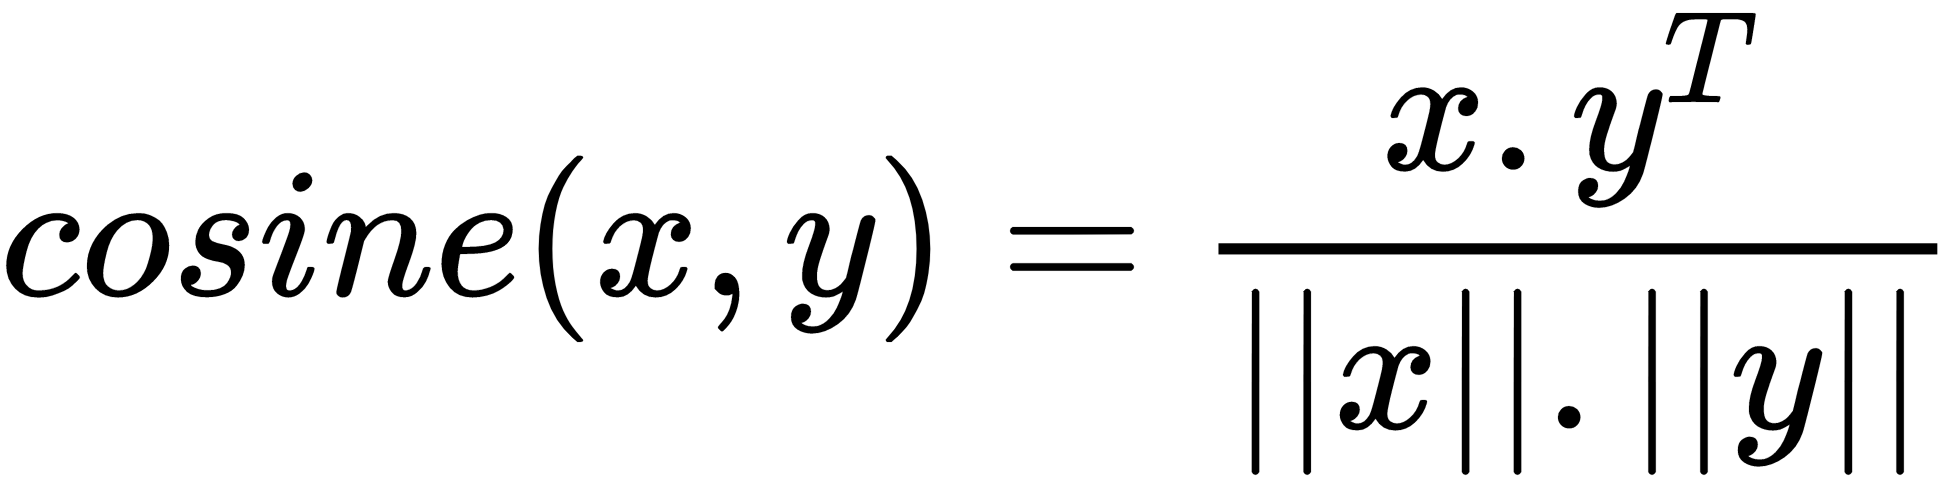

output yang didapat antara range -1 sampai 1. Score yang hampir mencapai 1 artinya kedua entitas tersebut sangatlah mirip sedangkan score yang hampir mencapai -1 artinya kedua entitas tersebut adalah beda

In [355]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [356]:
cosine_sim

array([[1.        , 0.15430335, 0.35355339, ..., 0.        , 0.        ,
        0.13608276],
       [0.15430335, 1.        , 0.10910895, ..., 0.        , 0.        ,
        0.        ],
       [0.35355339, 0.10910895, 1.        , ..., 0.        , 0.08703883,
        0.09622504],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08703883, ..., 0.        , 1.        ,
        0.10050378],
       [0.13608276, 0.        , 0.09622504, ..., 0.        , 0.10050378,
        1.        ]])

#### Pertanyaan 5: Cara membuat content based recommender system

kita lakukan reverse mapping dengan judul sebagai index nya

In [358]:
indices = pd.Series(feature_df.index, index=feature_df['title']).drop_duplicates()
indices

title
The Love Expert              0
Yes or No                    1
Our Hospitality              2
The King of Kings            3
I Cover the Waterfront       4
                          ... 
UFC on ESPN               1055
Bozkir                    1056
Blue Story                1057
Typewriter                1058
Koko-di Koko-da           1059
Length: 1060, dtype: int64

In [367]:
def content_recommender(title):
    #mendapatkan index dari judul film yang disebutkan
    idx = indices[title]

    #menjadikan list dari array similarity cosine sim tadi
    #hint: cosine_sim[idx]
    sim_scores = list(enumerate(cosine_sim[idx]))

    #mengurutkan film dari similarity tertinggi ke terendah
    #hint: sorted(iter, key, reverse)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #untuk mendapatkan list judul dari item kedua sampe ke 11 (abaikan yang pertama karena yang pertama pasti judul film itu sendiri)
    sim_scores = sim_scores[1:11]

    #mendapatkan index dari judul-judul yang muncul di sim_scores
    movie_indices = [i[0] for i in sim_scores]

    #dengan menggunakan iloc, kita bisa panggil balik berdasarkan index dari movie_indices
    return base_df.iloc[movie_indices]

In [369]:
#rekomendasi dari content based recommender system
content_recommender('The Lion King')

,title,type,start,duration,genres,rating,votes,cast_name,director_name,writer_name
848,The Jungle Book,movie,2016.0,106.0,"[Adventure, Drama, Family]",7.4,250994,[Cristina Carrión Márquez],[Jon Favreau],"[Justin Marks, Rudyard Kipling]"
383,The Animals of Farthing Wood,tvSeries,1993.0,25.0,"[Adventure, Animation, Drama]",8.3,3057,[Francisco Bretas],"[Elphin Lloyd-Jones, Philippe Leclerc]","[Valerie Georgeson, Colin Dann, Jenny McDade, ..."
1002,Made in Abyss,tvSeries,2017.0,325.0,"[Adventure, Animation, Drama]",8.4,4577,[Hiroki Matsukawa],"[Masayuki Kojima, Hitoshi Haga, Shinya Iino, T...","[Akihito Tsukushi, Keigo Koyanagi, Hideyuki Ku..."
73,Robin and Marian,movie,1976.0,106.0,"[Adventure, Drama, Romance]",6.5,10830,[Joaquín Parra],[Richard Lester],[James Goldman]
232,The Edge,movie,1997.0,117.0,"[Action, Adventure, Drama]",6.9,65673,[Chris Kosloski],[Lee Tamahori],[David Mamet]
556,Made in Abyss: Journey's Dawn,movie,2019.0,139.0,"[Adventure, Animation, Fantasy]",7.4,81,[Hiroki Matsukawa],[Masayuki Kojima],[Akihito Tsukushi]
9,Boss of Lonely Valley,movie,1937.0,60.0,"[Action, Adventure, Drama]",6.2,41,[Bernard Loftus],[Ray Taylor],"[Frances Guihan, Forrest Brown]"
191,The Princess and the Goblin,movie,1991.0,82.0,"[Adventure, Animation, Comedy]",6.8,2350,[Simon Mayal],[József Gémes],"[Robin Lyons, George MacDonald]"
803,Ostwind,movie,2013.0,101.0,"[Adventure, Drama, Family]",6.8,1350,[Sina Müller],[Katja von Garnier],"[Kristina Magdalena Henn, Lea Schmidbauer]"
983,The Skinner Boys: Guardians of the Lost Secrets,tvSeries,2014.0,23.0,"[Adventure, Animation, Drama]",7.8,12,[Jo Boag],"[Pablo De La Torre, Eugene Linkov, Jo Boag]","[David Witt, John Derevlany, David Evans, Pete..."


In [370]:
#metadata dari film itu sendiri
base_df[base_df['title'] == 'The Lion King']

,title,type,start,duration,genres,rating,votes,cast_name,director_name,writer_name
974,The Lion King,movie,2019.0,118.0,"[Adventure, Animation, Drama]",6.9,185808,[Rainy Kala],[Jon Favreau],"[Jonathan Roberts, Jeff Nathanson, Irene Mecch..."


seperti kita lihat di sana, dengan membandingkan feature genre, cast_name, director_name, dan writer_name, recommender system bisa merekomendasikan daftar film yang memiliki feature paling mirip dengan judul yang kita mention.

<br> yang paling pertama adalah 'The Jungle Book', dengan director_name sama dengan director 'The Lion King', film yang lain memiliki genres yang typically sama dengan film 'The Lion King'
<br> Hal ini membuktikan bahwa content based recommender system kita telah berhasil

## BONUS - Creating Search Engine for Title

kamu tidak mungkin bisa ingat title film secara detail, bahkan mungkin ketika ingat 'lion king', kamu akan lupa untuk menambahkan 'the lion king', ketika judul film itu tidak detail, maka content based recommender system yang kamu build di atas akan gagal menemukan index judul tersebut.
<br> Oleh sebab itu, kita akan buat content based recommender system lagi yang berfungsi sebagai search engine dari bagian judul yang kamu ingat, misal hanya mengetik 'lion' akan keluar 3 rekomendasi judul teratas dari yang paling mirip

In [464]:
def search_title(title):
    #membuat judul menjadi lowercase
    title = title.lower()
    
    #database judul
    movie_upper = base_df['title']
    
    #membuat semua judul dari database judul menjadi lowercase
    movie_db = base_df['title'].apply(lambda row: row.lower())
    #append title ke movie_db supaya nanti bisa dibandingkan
    movie_db = movie_db.append(pd.Series(title)).reset_index(drop=True)
    
    #memasukkan movie_db menjadi vector dan menghitung similari dari pairwise judul
    sim_matrix = count.fit_transform(movie_db)
    sim_pairwise = cosine_similarity(sim_matrix, sim_matrix)
    
    #reverse mapping menjadikan judul sebagai index
    search_indices = pd.Series(movie_db.index, index=movie_db.values).drop_duplicates()
    #mendapatkan index dari title yang kita cari
    idx = search_indices[title]
    
    #mengubah model similarity menjadi list
    sim_scores = list(enumerate(sim_pairwise[idx]))
    #mengurutkan judul dari kemiripan tertinggi ke terendah
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #memunculkan 5 kecocokan teratas
    sim_scores = sim_scores[1:6]
    #memunculkan index dari 5 kecocokan teratas
    movie_indices = [i[0] for i in sim_scores]

    return movie_upper.loc[movie_indices]

In [469]:
search_title('lion')

974       The Lion King
1005        Lion Killer
0       The Love Expert
1             Yes or No
2       Our Hospitality
Name: title, dtype: object

Dari contoh di atas, ketika kita input hanya 'lion' search engine akan mencari kecocokan secara otomatis dari semua judul yang kita store dalam movie_db, mengurutkan kecocokan nya dan menampilkan 5 teratas.
<br> <br> Setelah kita membuat search engine untuk judul ini maka kita bisa mencari content_recommender dari judul yang kita inginkan